Laboratorium Nr.3 

Asymilacja danych (data assimilation) 

 

1. Wybrać parametry dla swojego modelu (model bazowy), tak by produkowały jak najbardziej złożoną trajektorię. Na wykresie pokazać, jak wygląd ta zmienność w czasie każdej zmiennej dynamicznej x. Zrobić wykres 3D w przestrzeni fazowej. Wybrać także drugi model (startowy) z wyraźnie innymi parametrami, ale nie drastycznie innymi! UWAGA: Parametrami są także wartości początkowe x(0). 

2. Wybrać odcinek czasu, który nazwiemy przedziałem uczenia. 

3. Tak jak pokazano na rysunku poniżej dokonać próbkowania dla każdej zmiennej dynamicznej w zdefiniowanym przedziale uczenia (B) dla modelu bazowego. Zamiast wielu zmiennych dynamicznych można zdefiniować pewną pojedynczą miarę (np. w przypadku, gdy zmienne dynamiczne opisują dynamikę różnych populacji taką pojedynczą miarą może być ich suma, lub tylko jedna najważniejsza zmienna dynamiczna). Proszę wybrać rozsądną gęstość próbkowania tzn taką by oddawała on mniej więcej kształt krzywej. 

    
4. Na podstawie wygenerowanych danych przy pomocy metod asymilacji danych (patrz niżej) dopasować model startowy do tych danych (model dopasowany). 

5. Porównać parametry modelu bazowego do tych dopasowanych metodami asymilacji danych. W przypadku drastycznych różnic zwiększyć ilość danych (np. dodając dane do wszystkich zmiennych dynamicznych). 

6. Dokonać przewidywania „w przód” (przedział C na rysunku) i „w tył” (przedział A). W przejrzysty sposób pokazać jakość przewidywań. Policzyć RMS. Na wykresach pokazywać różnicę między modelem bazowym a dopasowanym. 

7. Pokazać, jak wygląda jakość przewidywania w zależności od szerokości przedziału treningowego: mała szerokość, średnia duża. Do szerokości przedziału dopasować ilość próbek. Patrz też rysunek poniżej. 

 

OPROGRAMOWANIE: 

Rekomenduję użycie repozytorium pyPESTO.  Użyteczne linki: 

pyPESTO/doc/example/fixed_parameters.ipynb at main · ICB-DCM/pyPESTO · GitHub 

GitHub - nansencenter/DA-tutorials: Tutorials on data assimilation (DA) and the EnKF 

AMICI in pyPESTO — pyPESTO documentation 

SciMLSensitivity.jl/docs/src/tutorials/parameter_estimation_ode.md at master · SciML/SciMLSensitivity.jl · GitHub 

ApplNumComp/L13 Parameter Estimation in Python.md at master · ashleefv/ApplNumComp · GitHub 

global optimization - How to fit the parameters of differential equations with known data? - MathOverflow 

 

 

# Model

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_predator_prey(params, dt=0.01):
    """
    Simulates a three-species predator-prey system with dynamic hunting efficiency.

    Parameters:
    - params (dict): A dictionary containing all model parameters:
        - 'prey_growth_rate': Growth rate of Species A (prey)
        - 'predation_rate_A_by_B': Base predation rate of Species A by Species B
        - 'predation_rate_B_by_C': Base predation rate of Species B by Species C
        - 'mortality_rate_B': Mortality rate of Species B
        - 'mortality_rate_C': Mortality rate of Species C
        - 'reproduction_rate_B_from_A': Reproduction rate of Species B from consuming Species A
        - 'reproduction_rate_C_from_B': Reproduction rate of Species C from consuming Species B
        - 'predation_rate_A_on_C': Harm or predation rate of Species A on Species C
        - 'hunting_efficiency_reduction': Reduction factor for predation efficiency of the most populated species
        - 'initial_population_A': Initial population of Species A (prey)
        - 'initial_population_B': Initial population of Species B (predator 1)
        - 'initial_population_C': Initial population of Species C (predator 2)
        - 'start_time': Start time for simulation
        - 'end_time': End time for simulation
    - dt (float): Time step for simulation (default: 0.01).

    Returns:
    - t: Array of time points
    - population_A, population_B, population_C: Population dynamics for Species A, B, and C
    """
    # Initialize time and population arrays
    t = np.arange(params['start_time'], params['end_time'], dt)
    population_A = np.zeros(len(t))  # Species A (prey)
    population_B = np.zeros(len(t))  # Species B (predator 1)
    population_C = np.zeros(len(t))  # Species C (predator 2)

    # Set initial conditions
    population_A[0] = params['initial_population_A']
    population_B[0] = params['initial_population_B']
    population_C[0] = params['initial_population_C']

    # Simulate dynamics using the parameters in the dictionary
    for i in range(1, len(t)):
        # Determine the most populated species and reduce its hunting efficiency
        most_populated = max(population_A[i-1], population_B[i-1], population_C[i-1])
        hunting_efficiency_factor = 1 - params['hunting_efficiency_reduction'] * (most_populated / (most_populated + 1))

        population_A[i] = population_A[i-1] + dt * (
            params['prey_growth_rate'] * population_A[i-1] -
            hunting_efficiency_factor * params['predation_rate_A_by_B'] * population_A[i-1] * population_B[i-1]
        )
        population_B[i] = population_B[i-1] + dt * (
            -params['mortality_rate_B'] * population_B[i-1] +
            hunting_efficiency_factor * params['reproduction_rate_B_from_A'] * population_A[i-1] * population_B[i-1] -
            hunting_efficiency_factor * params['predation_rate_B_by_C'] * population_B[i-1] * population_C[i-1]
        )
        population_C[i] = population_C[i-1] + dt * (
            -params['mortality_rate_C'] * population_C[i-1] +
            hunting_efficiency_factor * params['reproduction_rate_C_from_B'] * population_B[i-1] * population_C[i-1] -
            hunting_efficiency_factor * params['predation_rate_A_on_C'] * population_A[i-1] * population_C[i-1]
        )

    return t, population_A, population_B, population_C


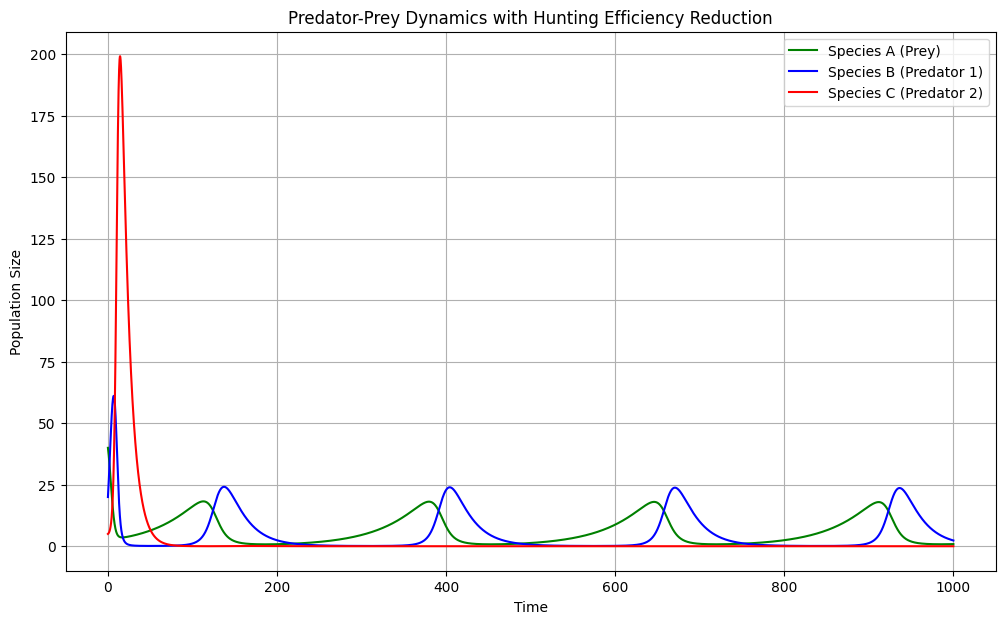

In [ ]:
# Define parameters with new hunting efficiency factor
params = {
    'prey_growth_rate': 0.02,                     # Growth rate of Species A (prey)
    'predation_rate_A_by_B': 0.005,               # Base predation rate of Species A by Species B
    'predation_rate_B_by_C': 0.002,               # Base predation rate of Species B by Species C
    'mortality_rate_B': 0.05,                     # Mortality rate of Species B
    'mortality_rate_C': 0.1,                     # Mortality rate of Species C
    'reproduction_rate_B_from_A': 0.01,           # Reproduction rate of Species B from consuming A
    'reproduction_rate_C_from_B': 0.01,           # Reproduction rate of Species C from consuming B
    'predation_rate_A_on_C': 0.001,               # Predation or harm rate of Species A on Species C
    'hunting_efficiency_reduction': 0.1,          # Reduction factor for most populated species' hunting efficiency
    'initial_population_A': 40,                   # Initial population of Species A (prey)
    'initial_population_B': 20,                   # Initial population of Species B (predator 1)
    'initial_population_C': 5,                   # Initial population of Species C (predator 2)
    'start_time': 0,                              # Start time for simulation
    'end_time': 1000                               # End time for simulation
}

# Simulate populations
t, pop_A, pop_B, pop_C = simulate_predator_prey(params)

# Plot results
plt.figure(figsize=(12, 7))
plt.plot(t, pop_A, label='Species A (Prey)', color='green')
plt.plot(t, pop_B, label='Species B (Predator 1)', color='blue')
plt.plot(t, pop_C, label='Species C (Predator 2)', color='red')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Predator-Prey Dynamics with Hunting Efficiency Reduction')
plt.legend()
plt.grid()
plt.show()


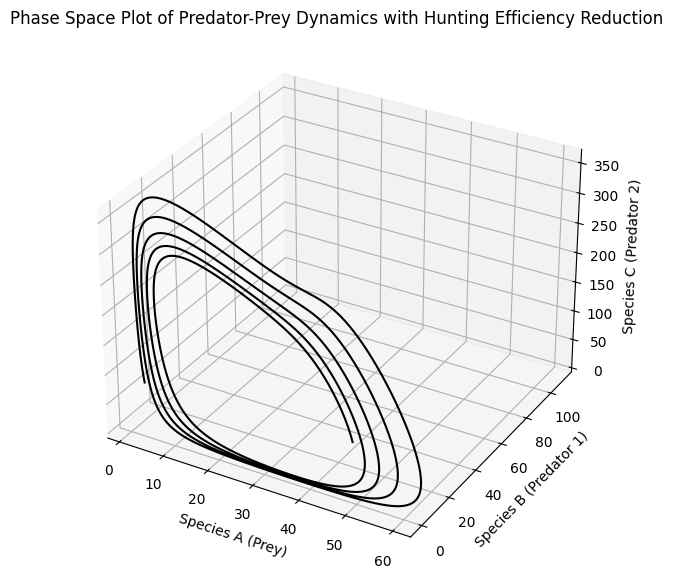

In [45]:
#phase space plot 3d
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pop_A, pop_B, pop_C, color='black')
ax.set_xlabel('Species A (Prey)')
ax.set_ylabel('Species B (Predator 1)')
ax.set_zlabel('Species C (Predator 2)')

plt.title('Phase Space Plot of Predator-Prey Dynamics with Hunting Efficiency Reduction')
plt.show()
